In [6]:
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
usecols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode','popularity', 'speechiness', 'tempo', 'valence']

dataset = pd.read_csv("data.csv", header = 0, usecols=usecols)
#robert says we need this idk
dataset = dataset[~dataset.duplicated()==1]
#TODO also normalize (e.g. length)


y = dataset.pop('popularity')

Xdf = dataset
X = Xdf.to_numpy()

headers = list(Xdf.columns.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
clf = tree.DecisionTreeRegressor(max_depth=9)
clf = clf.fit(X_train, y_train)

In [9]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, X, y, cv=cv)

array([0.41218145, 0.40218906, 0.40979858, 0.4134463 , 0.41177123])

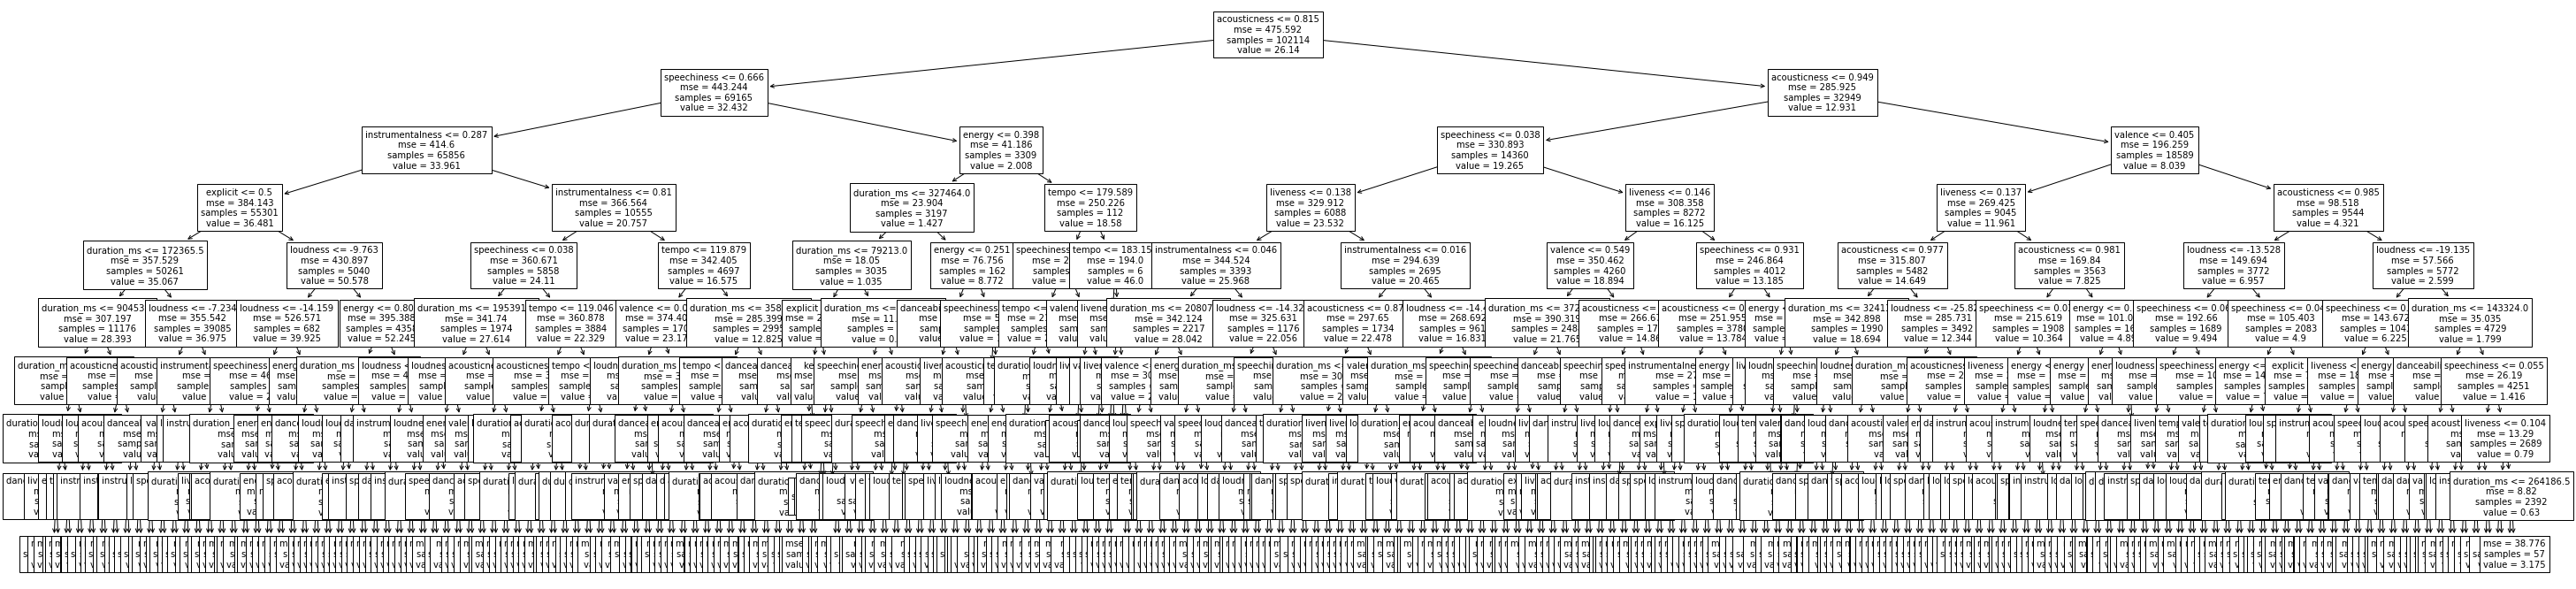

In [10]:
clf.get_depth()
plt.figure(figsize=(50,12))
tree.plot_tree(clf,  fontsize=10, feature_names=headers)
plt.show()